## prepare training, validation and test data sets

Read original data from "contigs_func" directory and merge it with labels from "tn.contig.filter.tsv"

Separate the data into training, validation and test data sets. 
Thereby stratify the data along the length of genome sequences. 
The size of each set will be determined with the parameters "validation_frac","test_frac" and "train_frac".
Define these parameters below.

Tokenize the protein families (simply by assigning a number to each unique protein familiy)

Create chunks from this data of size "chunk_len" and with an offset of "chunk_offset". 
Define these parameters below.

Output:

    "df_chunked" (pandas DataFrame)
        contains all chunks with token_ids and labels. 
        The column "set" assigns eauch chunk to test, validation and train sets. 
        Other columns in this dataframe serve for finding the data quickly in the original files

    "tokenize_table" (dictionary)
        contains the translation from token to token_ids
            0 = token for padding
            1 - 10 : reserved
            
    Both objects will be save as a shelve object into "prep_trainvalidationtest_1.*"
    For reading the results please see "read_trainvalidationtest_1.ipynb" 

In [1]:
import pandas as pd
import os
import numpy as np
import collections
import timeit
from matplotlib import pyplot as plt
import shelve

### define parameters

In [2]:
bins = ((1,30),(30,500),(500,999999)) # for stratifying the data along the length of genome sequences
                                      #(1,30): >=1 and <30
validation_frac = 0.05
test_frac = 0.05
train_frac = 1 - validation_frac - test_frac

chunk_len = 150
chunk_offset = 50

np.random.seed(4711)

### read data into a dictionary

In [3]:
df = pd.read_csv(os.path.join("..", "data", "original_data", "tn.contig.filter.tsv"), sep="\t")

In [4]:
start_time = timeit.default_timer()

col_origin = []
col_tokens = []
col_labels = []
col_length = []
col_num_TE = []
col_max_len_TE = []

for sequence in sorted(os.listdir(os.path.join("..", "data", "original_data", "contigs_func"))):
    df_c = pd.read_csv(os.path.join("..", "data", "original_data", "contigs_func", sequence), 
                       sep = "\t", 
                       names = ("tokens", "strand"), 
                       skiprows = (1) )
    contig_id = sequence.split(".")[0]
    num_TE = 0
    max_len_TE = 0 
    TE_np = np.zeros(df_c.shape[0])
    
    for index, row in df[df["contig_ID"] == int(contig_id)].iterrows():
        num_TE = num_TE + 1
        max_len_TE = max(max_len_TE, row["len"])        
        
        for i in range(row["start"]-1, row["end"]):
            TE_np[i] = 1
    
    tokens = df_c["tokens"].to_list()
    TE = list(TE_np)
    length = len(tokens)
    
    col_origin.append(sequence)
    col_tokens.append(tokens)
    col_labels.append(TE)
    col_length.append(length)
    col_num_TE.append(num_TE)
    col_max_len_TE.append(max_len_TE)
    
df_a = pd.DataFrame({ "origin": col_origin,
                      "tokens": col_tokens,
                      "labels": col_labels,
                      "length": col_length,
                      "num_TE": col_num_TE,
                      "max_len_TE": col_max_len_TE 
                    })
    
elapsed = timeit.default_timer() - start_time
print(elapsed)

56.47137161903083


In [5]:
df_a["origin"].shape[0]

9226

In [6]:
df_a.head()

,origin,tokens,labels,length,num_TE,max_len_TE
0,100.fasta,"[mcl00578, mcl00294, mcl01096, mcl01000, mcl01...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5269,15,3
1,10000.fasta,"[mcl02431, mcl06548, mcl04067, mcl09083, mcl09...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",123,0,0
2,10008.fasta,"[mcl0000X, mcl01971, mcl02107, mcl01276, mcl01...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4346,6,4
3,10009.fasta,"[mcl09252, mcl09004, mcl11223, mcl09170, mcl02...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",212,13,3
4,10013.fasta,"[mcl01241, mcl00150, mcl01386, mcl00603, mcl00...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4221,7,19


In [7]:
df_a.to_csv('../data/characteristics.csv')

### split data into training, validation and test data

 stratifying the data along length of genome sequences: df_a["bin"])
 
 assigning each data row to a data set: df_a["set"] 
 
    0 = training data 
    1 = validation data 
    2 = test data 

In [8]:
df_a["bin"] = "999"
df_a["set"] = "999"

In [9]:
i = 0
for bin in bins:
    df_a["bin"].where((df_a["length"] >= bin[0]) & (df_a["length"] < bin[1]), i, inplace = True)
    df_a.loc[df_a["bin"] == i, "set"] = np.random.choice(3,
                                                         df_a["set"][df_a["bin"] == i].count(),  
                                                         p = [train_frac, validation_frac, test_frac])
    i = i + 1 

In [10]:
df_a.head(1)

,origin,tokens,labels,length,num_TE,max_len_TE,bin,set
0,100.fasta,"[mcl00578, mcl00294, mcl01096, mcl01000, mcl01...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5269,15,3,1,2


### check size of sets

In [11]:
df_a["set"].groupby(df_a["set"]).count()

set
0    8274
1     475
2     477
Name: set, dtype: int64

### check distribution of length of genome sequences in training, validation and test sets

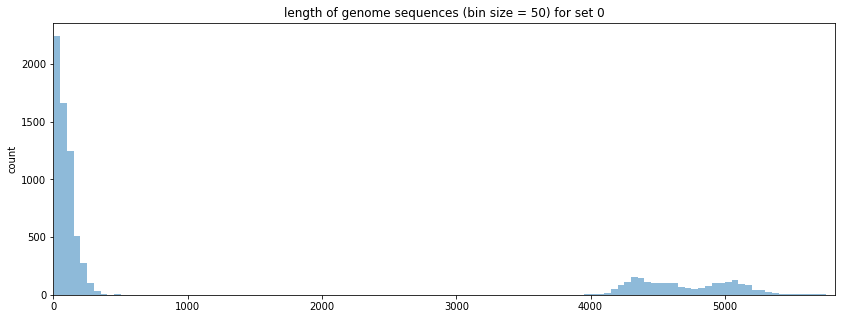

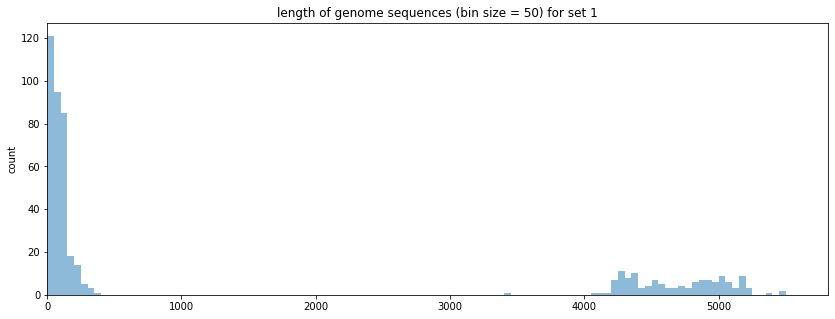

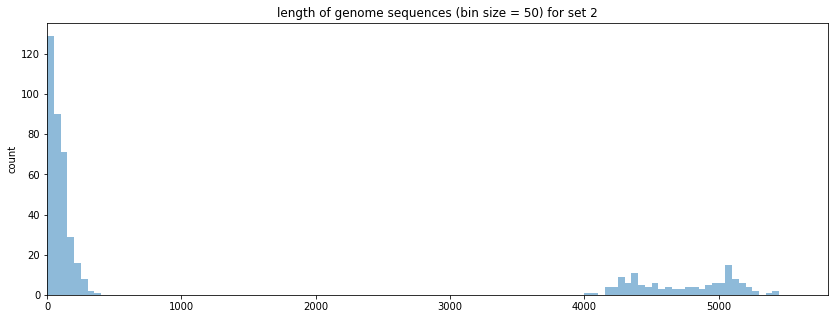

In [12]:
max_data = df_a["length"].max()

for i in range(0,3):
    data = df_a["length"][df_a["set"] == i]

    # fixed bin size
    bin_size = 50
    bins = np.arange(1, max(data)+5, bin_size) # fixed bin size

    fig = plt.figure(figsize=(14,5))

    plt.xlim([0, max_data])

    plt.hist(data, bins=bins, alpha=0.5)
    plt.title('length of genome sequences (bin size = {:n}) for set {:n}'.format(bin_size, i))
    plt.ylabel('count')

    plt.show()

### check distribution of number of TEs in genome sequences in training, validation and test sets

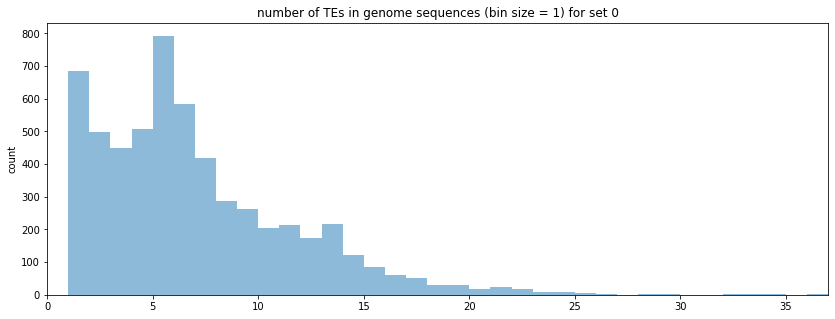

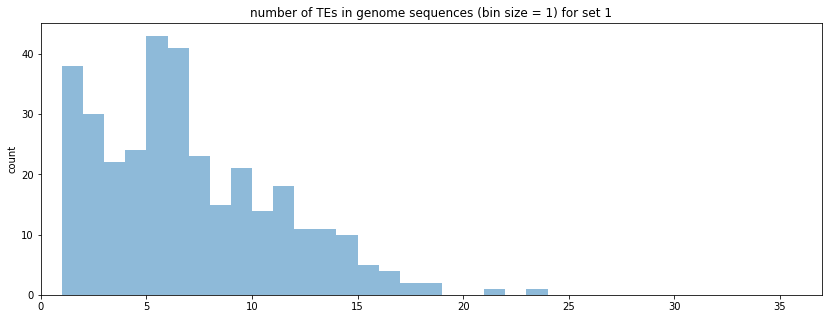

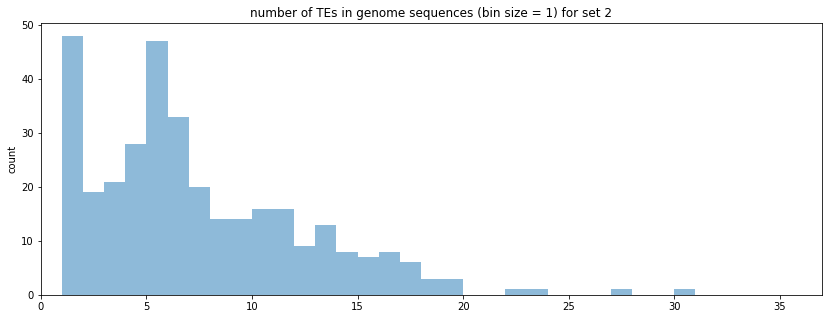

In [13]:
max_data = df_a["num_TE"].max()

for i in range(0,3):
    data = df_a["num_TE"][df_a["set"] == i]

    # fixed bin size
    bin_size = 1
    bins = np.arange(1, max(data)+5, bin_size) # fixed bin size

    fig = plt.figure(figsize=(14,5))

    plt.xlim([0, max_data])

    plt.hist(data, bins=bins, alpha=0.5)
    plt.title('number of TEs in genome sequences (bin size = {:n}) for set {:n}'.format(bin_size, i))
    plt.ylabel('count')

    plt.show()

### check distribution of length of TEs in genome sequences in training, validation and test sets

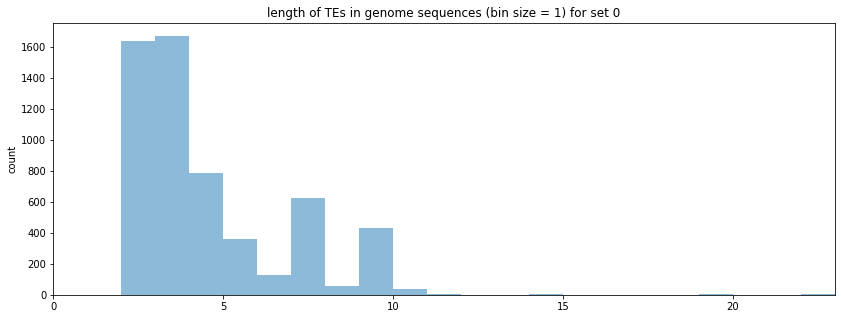

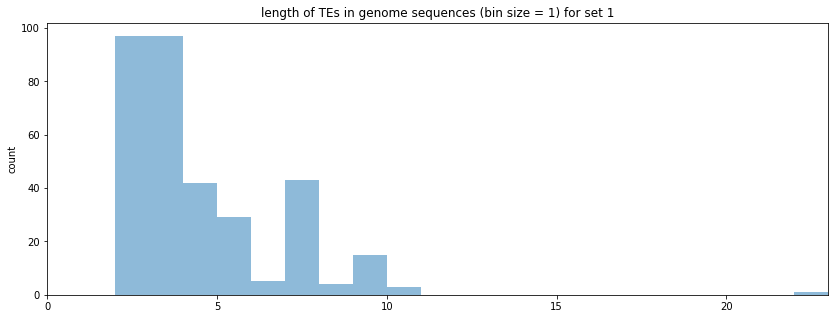

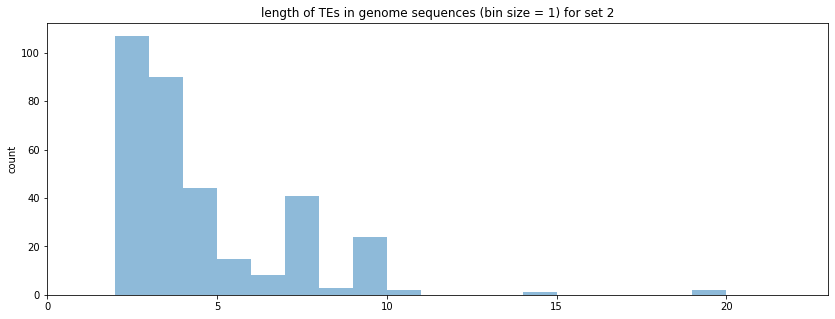

In [14]:
max_data = df_a["max_len_TE"].max()

for i in range(0,3):
    data = df_a["max_len_TE"][df_a["set"] == i]

    # fixed bin size
    bin_size = 1
    bins = np.arange(1, max(data)+5, bin_size) # fixed bin size

    fig = plt.figure(figsize=(14,5))

    plt.xlim([0, max_data])

    plt.hist(data, bins=bins, alpha=0.5)
    plt.title('length of TEs in genome sequences (bin size = {:n}) for set {:n}'.format(bin_size, i))
    plt.ylabel('count')

    plt.show()

### assign token_ids to tokens

In [15]:
c = collections.Counter()
for index, row in df_a.iterrows():
    c.update(row["tokens"])

In [16]:
summe = 0
for x in c.items():
    summe = summe + x[1]
print("number of elements:", summe)   

number of elements: 12041165


In [17]:
tokens = list(c.keys())
tokenize_table = dict(zip(tokens, list(np.arange(11,len(tokens)+11)))) # reserve 0 to 10 for special token_ids

df_a["token_ids"] = df_a["tokens"].apply(lambda x: [ tokenize_table[t] for  t in x])

In [18]:
for x in list(c.most_common(20)):
    print(x, tokenize_table[x[0]])

('mcl0000X', 41094) 31
('mcl00001', 8227) 6287
('mcl00002', 5672) 7462
('mcl00003', 5316) 6754
('mcl00004', 4992) 1608
('mcl00005', 4911) 3355
('mcl00006', 4749) 1607
('mcl00008', 4603) 1249
('mcl00007', 4530) 2524
('mcl00009', 4299) 5943
('mcl00010', 4270) 444
('mcl00011', 3886) 5084
('mcl00012', 3648) 4141
('mcl00014', 3637) 443
('mcl00013', 3563) 877
('mcl00015', 3528) 445
('mcl00019', 3355) 256
('mcl00017', 3354) 9208
('mcl00018', 3317) 673
('mcl00016', 3291) 4174


In [19]:
c.most_common()[-20000:-1]

[('mcl12591', 54),
 ('mcl12822', 54),
 ('mcl12932', 54),
 ('mcl13009', 54),
 ('mcl12888', 54),
 ('mcl12601', 54),
 ('mcl12420', 54),
 ('mcl12949', 54),
 ('mcl12924', 54),
 ('mcl12715', 54),
 ('mcl12908', 54),
 ('mcl12829', 54),
 ('mcl12774', 54),
 ('mcl12777', 54),
 ('mcl12767', 54),
 ('mcl12770', 54),
 ('mcl12762', 54),
 ('mcl12865', 54),
 ('mcl12582', 54),
 ('mcl12686', 54),
 ('mcl12651', 54),
 ('mcl12596', 54),
 ('mcl12904', 54),
 ('mcl12503', 54),
 ('mcl12492', 54),
 ('mcl12748', 54),
 ('mcl12538', 54),
 ('mcl12618', 54),
 ('mcl12926', 54),
 ('mcl12638', 54),
 ('mcl12853', 54),
 ('mcl12871', 54),
 ('mcl12804', 54),
 ('mcl12951', 54),
 ('mcl13004', 54),
 ('mcl12581', 54),
 ('mcl12874', 54),
 ('mcl12718', 54),
 ('mcl12293', 54),
 ('mcl12659', 54),
 ('mcl12444', 54),
 ('mcl12587', 54),
 ('mcl11916', 54),
 ('mcl12584', 54),
 ('mcl12452', 54),
 ('mcl12387', 54),
 ('mcl12355', 54),
 ('mcl12824', 54),
 ('mcl12614', 54),
 ('mcl12851', 54),
 ('mcl12825', 54),
 ('mcl12750', 54),
 ('mcl12531'

In [20]:
df_a.head(1)

,origin,tokens,labels,length,num_TE,max_len_TE,bin,set,token_ids
0,100.fasta,"[mcl00578, mcl00294, mcl01096, mcl01000, mcl01...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5269,15,3,1,2,"[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2..."


### compute the chunks

paramters to be set before (see top of the notebook):

    chunk_len

    chunk_offset

In [21]:
raw_mask = np.zeros(10)

In [22]:
raw_mask[0:7] = np.ones(7)

In [23]:
raw_mask

array([1., 1., 1., 1., 1., 1., 1., 0., 0., 0.])

In [24]:
raw_masks = np.zeros(10+ 3).astype(int)
raw_masks[0:10] = np.ones(10).astype(int)
raw_masks
raw_masks[3:13]

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0])

In [25]:
start_time = timeit.default_timer()

origin = []
chunk = []
dset = []
tokens = []
token_ids = []
attention_masks = []
labels = []

for index, row in df_a.iterrows():
    l = len(row["token_ids"])
    raw_t = np.zeros(max(l + chunk_offset, chunk_len)).astype(int)
    raw_t[0: l] = row["token_ids"]
    raw_l = np.zeros(max(l + chunk_offset, chunk_len)).astype(int)
    raw_l[0: l] = row["labels"]
    raw_masks = np.zeros(max(l + chunk_offset, chunk_len)).astype(int)
    raw_masks[0:l] = np.ones(l).astype(int)
    raw_tokens = ['pad' for i in range(0,max(l + chunk_offset, chunk_len))]
    raw_tokens[0: l] = row["tokens"]
    chunk_n = 1
    
    for i in range(0,max(1, l + chunk_offset - chunk_len), chunk_offset):
        origin.append(row["origin"])
        chunk.append(chunk_n)
        dset.append(row['set'])
        token_ids.append(raw_t[i:i+chunk_len])
        labels.append(raw_l[i:i+chunk_len])
        attention_masks.append(raw_masks[i:i+chunk_len])
        tokens.append(raw_tokens[i:i+chunk_len])
        chunk_n = chunk_n + 1

df_chunked = pd.DataFrame({"origin": origin,
                           "chunk": chunk,
                           "set": dset,
                           "tokens": tokens,
                           "token_ids": token_ids,
                           "attention_masks" : attention_masks,
                           "labels": labels})

elapsed = timeit.default_timer() - start_time
print(elapsed)

5.983499150723219


### finalize dataframe

a dataframe with sets: "training", "validation" and "test",

In [26]:
df_chunked.loc[df_chunked["set"] == 0, "set"] = "training"
df_chunked.loc[df_chunked["set"] == 1, "set"] = "validation"
df_chunked.loc[df_chunked["set"] == 2, "set"] = "test"

### some final checks

In [27]:
print("number of files scanned:",df_chunked["origin"].nunique())
print("chunks overall :", df_chunked.shape[0])

for i in ("training", "validation", "test"):
    print(i, "chunks:", df_chunked["set"][df_chunked["set"] == i].count())

number of files scanned: 9226
chunks overall : 234563
training chunks: 209159
validation chunks: 12736
test chunks: 12668


In [28]:
to1 = list(df_chunked[(df_chunked["origin"] == "20.fasta") & (df_chunked["chunk"] <= 3)]["tokens"])

In [29]:
t1 = list(df_chunked[(df_chunked["origin"] == "20.fasta") & (df_chunked["chunk"] <= 3)]["token_ids"])

In [30]:
l1 = list(df_chunked[(df_chunked["origin"] == "20.fasta") & (df_chunked["chunk"] <= 3)]["labels"])

In [31]:
m1 = list(df_chunked[(df_chunked["origin"] == "20.fasta") & (df_chunked["chunk"] <= 3)]["attention_masks"])

In [32]:
to1

[['mcl00059',
  'mcl07910',
  'mcl07920',
  'mcl07935',
  'mcl07933',
  'mcl08867',
  'mcl07944',
  'mcl08857',
  'mcl07940',
  'mcl07891',
  'mcl06089',
  'mcl07707',
  'mcl07809',
  'mcl07830',
  'mcl07917',
  'mcl08918',
  'mcl08970',
  'mcl08902',
  'mcl00035',
  'mcl09187',
  'mcl08882',
  'mcl08935',
  'mcl08879',
  'mcl08027',
  'mcl07905',
  'mcl07951',
  'mcl02867',
  'mcl07972',
  'mcl07983',
  'mcl08963',
  'mcl07901',
  'mcl08956',
  'mcl07896',
  'mcl09074',
  'mcl07937',
  'mcl09001',
  'mcl08827',
  'mcl07926',
  'mcl08833',
  'mcl08823',
  'mcl09147',
  'mcl09008',
  'mcl08959',
  'mcl08910',
  'mcl08758',
  'mcl08798',
  'mcl08811',
  'mcl08754',
  'mcl08846',
  'mcl08832',
  'mcl08783',
  'mcl08981',
  'mcl07062',
  'mcl00007',
  'mcl07314',
  'mcl07562',
  'mcl07572',
  'mcl07565',
  'mcl07521',
  'mcl07500',
  'mcl07473',
  'mcl06099',
  'mcl06213',
  'mcl06116',
  'mcl06148',
  'mcl06102',
  'mcl06124',
  'mcl06180',
  'mcl06093',
  'mcl06138',
  'mcl06092',
  'mcl

In [33]:
t1

[array([ 4910,  6224,  6225,  6226,  6227,  6228,  6229,  6230,  6231,
         6232,  9319,  9331,  6238,  6239,  6240,  6241,  6242,  6243,
          786,  6244,  6245,  6246,  6247,  6248,  6249,  6250,  6251,
         6253,  6254,  6255,  6256,  6257,  6258,  6259,  6260,  6261,
         6262,  6263,  6264,  6265,  6266,  6267,  6268,  6269,  6270,
         6271,  6272,  6273,  6274,  6276,  6277,  6278,  6279,  2524,
         6305,  7461,  7460,  7459,  7458,  7457,  7456,  1848,  1847,
         1846,  1845,  1844,  1843,  1842,  1841,  1840,  1839,  1838,
         1837,  1836,  7455,  7454,  7453,  7452,  6307,  7440,  1242,
         7451,  7450,  6317,  7449,  8654,  8653,  8652,  9442,  1557,
         9443,  9444,  6322,  9445,  6323,  6325,  6327,  6328,  5487,
         6329,  6330,  7487,  7486,  7485,  6341,  7484,  7483,  6299,
         6287, 13025,  8961,  7358, 10064,  9453,  6287,  9763, 10672,
         9548,  3927,  3926,  6940,  7289,  7288,  7287,  8969,   152,
      

In [34]:
m1

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [35]:
l1

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [36]:
# check correct length for short sequences
print(len(list(df_chunked[df_chunked["origin"] == "2908.fasta"].attention_masks)[0]))
print(len(list(df_chunked[df_chunked["origin"] == "2908.fasta"].tokens)[0]))
print(len(list(df_chunked[df_chunked["origin"] == "2908.fasta"].token_ids)[0]))
print(len(list(df_chunked[df_chunked["origin"] == "2908.fasta"].labels)[0]))

150
150
150
150


In [37]:
# check correct length for short sequences
print(list(df_chunked[df_chunked["origin"] == "2908.fasta"].attention_masks)[0])
print(list(df_chunked[df_chunked["origin"] == "2908.fasta"].tokens)[0])
print(list(df_chunked[df_chunked["origin"] == "2908.fasta"].token_ids)[0])
print(list(df_chunked[df_chunked["origin"] == "2908.fasta"].labels)[0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
['mcl10368', 'mcl10874', 'mcl10393', 'mcl10400', 'mcl09916', 'mcl08845', 'mcl03725', 'mcl02745', 'mcl03819', 'mcl09697', 'mcl03860', 'mcl02697', 'mcl07222', 'mcl07707', 'mcl06089', 'mcl10577', 'mcl10549', 'mcl10417', 'mcl11836', 'mcl10439', 'mcl10484', 'mcl10995', 'mcl09314', 'mcl08118', 'mcl04263', 'mcl13056', 'mcl11220', 'mcl12916', 'mcl09144', 'mcl11511', 'mcl11543', 'mcl10370', 'mcl00004', 'mcl00006', 'mcl07868', 'mcl10476', 'mcl06954', 'mcl00023', 'mcl03755', 'mcl04614', 'mcl09244', 'mcl04499', 'mcl07020', 'mcl00021', 'mcl09256', 'mcl07015', 'mcl09694', 'mcl04182', 'mcl11538', 'mcl10419', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'p

### final outputs

    "df_chunked" (pandas DataFrame)
        Contains all chunks with token_ids and labels. 
        The column "set" assigns eauch chunk to test, validation and train sets. 
        Other columns in this dataframe serve for finding the data qickly in the original files

    "tokenize_table" (dictionary)
        Contains the translation from token to token_ids
            0 = token for padding
            1 - 10 : reserved

In [38]:
df_chunked.head(2)

,origin,chunk,set,tokens,token_ids,attention_masks,labels
0,100.fasta,1,test,"[mcl00578, mcl00294, mcl01096, mcl01000, mcl01...","[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,100.fasta,2,test,"[mcl01236, mcl00376, mcl04030, mcl00368, mcl01...","[61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [39]:
tokenize_table

{'mcl00578': 11,
 'mcl00294': 12,
 'mcl01096': 13,
 'mcl01000': 14,
 'mcl01011': 15,
 'mcl00877': 16,
 'mcl02184': 17,
 'mcl01593': 18,
 'mcl01509': 19,
 'mcl00479': 20,
 'mcl01349': 21,
 'mcl00991': 22,
 'mcl00222': 23,
 'mcl02873': 24,
 'mcl02541': 25,
 'mcl02440': 26,
 'mcl04043': 27,
 'mcl01304': 28,
 'mcl00914': 29,
 'mcl00896': 30,
 'mcl0000X': 31,
 'mcl00362': 32,
 'mcl00737': 33,
 'mcl01098': 34,
 'mcl01478': 35,
 'mcl00041': 36,
 'mcl02454': 37,
 'mcl00415': 38,
 'mcl00681': 39,
 'mcl02022': 40,
 'mcl01314': 41,
 'mcl00093': 42,
 'mcl01775': 43,
 'mcl00855': 44,
 'mcl00256': 45,
 'mcl02590': 46,
 'mcl02661': 47,
 'mcl00953': 48,
 'mcl01340': 49,
 'mcl02050': 50,
 'mcl03182': 51,
 'mcl01178': 52,
 'mcl01055': 53,
 'mcl00744': 54,
 'mcl00638': 55,
 'mcl01715': 56,
 'mcl01840': 57,
 'mcl01411': 58,
 'mcl01215': 59,
 'mcl00834': 60,
 'mcl01236': 61,
 'mcl00376': 62,
 'mcl04030': 63,
 'mcl00368': 64,
 'mcl01015': 65,
 'mcl01308': 66,
 'mcl00983': 67,
 'mcl01928': 68,
 'mcl02129': 6

### save results

for reading the results please see "read_trainvalidationtest_1.ipynb" 

In [40]:
results = shelve.open(os.path.join("..", "data", "prep_trainvalidationtest_1"))
results["chunks"] = df_chunked
results["tokenize_table"] = tokenize_table
results.close

<bound method Shelf.close of <shelve.DbfilenameShelf object at 0x14b7496d3d30>>

In [42]:
import pickle

df_chunked[df_chunked["set"]=="test"].to_pickle('../data/processed_data/test_set.pkl')
df_chunked[df_chunked["set"]=="training"].to_pickle('../data/processed_data/training_set.pkl')
df_chunked[df_chunked["set"]=="validation"].to_pickle('../data/processed_data/validation_set.pkl')

with open('../data/processed_data/tokenize_table.pkl', 'wb') as f:
    pickle.dump(tokenize_table, f)